# AnimeGM - Autoencoder - Keras
GOAL: Generate new anime-style images
    
Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Generate a new image with random numbers
5. Transfer style to a photo
6. Examine results

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Imports

In [1]:
import pandas as pd
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns; sns.set()
from skimage.transform import resize
from os import listdir
from os.path import join
from skimage import data
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
%matplotlib inline

### Functions

In [2]:
# tf image preprocessing
# load, decoded and resize
def parse_image(image_path):
    image_string = tf.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_grayscaled = tf.image.rgb_to_grayscale(image_decoded)
    image_resized = tf.image.resize_images(image_grayscaled, [resize_dim, resize_dim])
    image_normalized = tf.divide(image_resized, 255)
    image_reshaped = tf.reshape(image_normalized, [-1])
    return image_reshaped

In [3]:
def show_image(image):
    image_reshape = image.reshape((resize_dim, resize_dim))
    plt.imshow(image_reshape, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def show_images(images, figsize=(10, 10)):
   # get the number of images
    n_images = images.shape[0]
    
    if n_images == 1:
        show_image(images[0])
        return
    
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i > n_images - 1:
            return
        image_reshape = images[i].reshape((resize_dim, resize_dim))
        im = axi.imshow(image_reshape, cmap='gray')

### Variables

In [5]:
dir_name = 'danbooru-small'

In [6]:
n_train = 2200
n_test = 10

resize_dim = 28
n_features = resize_dim * resize_dim

In [7]:
# hyper parameters~~~~
batch_size = 50
n_batches = int(n_train / batch_size)
n_epochs = 10

### Prepare data

In [8]:
# get filenames and join paths as np array
base_filenames = listdir(dir_name)
filename_paths = [join(dir_name, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)

In [9]:
# create paths for train and test
train_paths = filename_paths[:-n_test][:n_train]
test_paths = filename_paths[:n_test]

In [10]:
# reset the current graph and start over
reset_default_graph()

In [11]:
# create a dataset from the paths
image_paths = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(parse_image)
dataset = dataset.shuffle(buffer_size=n_train)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

# iterators
iter = dataset.make_initializable_iterator()
next_ele = iter.get_next()

## 2. Build a generative model
Lets build an autoencoder

In [12]:
import keras
from keras.layers import Dense, Input, Reshape
from keras.models import Model
from keras.optimizers import SGD

Using TensorFlow backend.


In [13]:
# size of encoded representations
encoding_dims = 32

In [14]:
# input placeholder
inputs = Input(shape=(n_features,))

# encoded represation of the input
encoded = Dense(256, activation='relu', name='encoder_0')(inputs)
encoded = Dense(128, activation='relu', name='encoder_1')(encoded)
encoded = Dense(64, activation='relu', name='encoder_2')(encoded)
encoded = Dense(encoding_dims, activation='relu', name='encoder_3')(encoded)

# decoded lossy reconstruction of the input
decoded = Dense(64, activation='relu', name='decoder_0')(encoded)
decoded = Dense(128, activation='relu', name='decoder_1')(decoded)
decoded = Dense(256, activation='relu', name='decoder_2')(decoded)
decoded = Dense(n_features, activation='sigmoid', name='decoder_3')(decoded)

In [15]:
# this model maps inputs to its reconstructions
autoencoder = Model(inputs, decoded)

In [16]:
# this model maps inputs to encoded represations
encoder = Model(inputs, encoded)

In [17]:
# create a placeholder for an ancoded input
encoded_input = Input(shape=(encoding_dims,))

# get the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-4]

# create decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Compile the model with cost and optimizer

In [18]:
autoencoder.compile(loss='binary_crossentropy', 
              optimizer='adadelta')

## 3. Train the model

In [19]:
# create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
# Initialize an iterator over a training dataset.
sess.run(iter.initializer, feed_dict={image_paths: train_paths})
    
for epoch_i in range(n_epochs):
    for batch_i in range(n_batches):
        # get batch
        batch_X = sess.run(next_ele)

        # train
        autoencoder.fit(batch_X, batch_X, epochs=1, batch_size=batch_size)

Epoch 1/1
50/50 [==============================] - 1s 12ms/step - loss: 0.6935
Epoch 1/1
50/50 [==============================] - 0s 559us/step - loss: 0.6934
Epoch 1/1
50/50 [==============================] - 0s 580us/step - loss: 0.6932
Epoch 1/1
50/50 [==============================] - 0s 580us/step - loss: 0.6929
Epoch 1/1
50/50 [==============================] - 0s 540us/step - loss: 0.6925
Epoch 1/1
50/50 [==============================] - 0s 561us/step - loss: 0.6926
Epoch 1/1
50/50 [==============================] - 0s 640us/step - loss: 0.6924
Epoch 1/1
50/50 [==============================] - 0s 560us/step - loss: 0.6920
Epoch 1/1
50/50 [==============================] - 0s 659us/step - loss: 0.6917
Epoch 1/1
50/50 [==============================] - 0s 661us/step - loss: 0.6916
Epoch 1/1
50/50 [==============================] - 0s 539us/step - loss: 0.6913
Epoch 1/1
50/50 [==============================] - 0s 520us/step - loss: 0.6909
Epoch 1/1
50/50 [========================

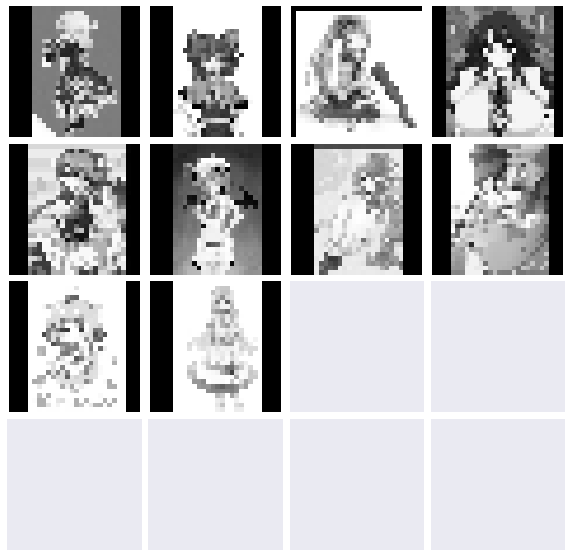

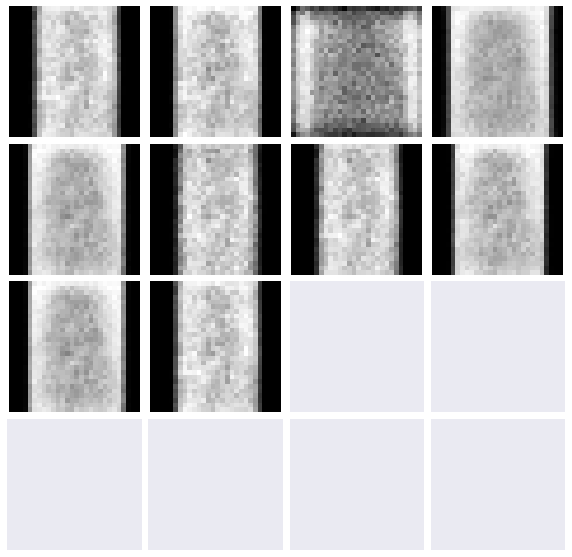

In [21]:
# Initialize an iterator over a testing dataset.
sess.run(iter.initializer, feed_dict={image_paths: test_paths})
    
# get batch
test_batch_X = sess.run(next_ele)

# show the test images
show_images(test_batch_X)

# create encoded images
encoded_imgs = autoencoder.predict(test_batch_X)

# create decoded images
decoded_imgs = autoencoder.predict(encoded_imgs)

# show the reconstructioned test images
show_images(decoded_imgs)